In [1]:
from train_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
import json

c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Moien'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = 200)
mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = 90)
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [5]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11]
if USER == MOIEN:
    train_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\train\\','D:\python\SoilNet\dataset\LUCAS_2015_all.csv',l8_bands=bands, transform=train_transform)
elif USER == NAFISEH:
    train_ds = SNDataset('C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\l8_images\\train',\
                        'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\LUCAS_2015_all.csv',l8_bands=bands, transform=train_transform) #Nafiseh 
if USER == MOIEN:
    test_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\test\\','D:\python\SoilNet\dataset\LUCAS_2015_all.csv',l8_bands=bands, transform=test_transform)
elif USER == NAFISEH:
    test_ds = SNDataset('C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\l8_images\\test',\
                        'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\LUCAS_2015_all.csv',l8_bands=bands, transform=test_transform) #Nafiseh 

In [6]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 100 if USER == NAFISEH else 5
LR_SCHEDULER = "step" # step, plateau or None
USE_SPATIAL_ATTENTION = True if USER == NAFISEH else False

In [7]:
from soilnet.soil_net import SoilNetFC, ResNet

In [8]:
# # Get image and label from custom DataLoader
# img_custom, label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [9]:
cv_results = {"train_loss": [],
               "test_loss": [],
               "MAE": [],
               "R2": []
    }

In [10]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
dt_string = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", dt_string)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2023_05_04_T_13_27


In [11]:
SEEDS = [1, 7, 14] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [12]:
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    if USE_SPATIAL_ATTENTION:
        model = ResNet(resnet_architecture="101+GLAM",cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    else:
        model = ResNet(resnet_architecture="101",cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    save_model_path = f"results/RUN_{dt_string}_{USER}.pth.tar" if idx == len(SEEDS)-1 else None
    
    results = train(model, train_dl, test_dl,
                    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
                    RMSELoss(), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path)

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['test_loss'].append(results['test_loss'])
    cv_results['MAE'].append(results['MAE'][0])
    cv_results['R2'].append(results['R2'][0])
    
    
        

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 13/13 [00:07<00:00,  1.73it/s, Train_Loss=0.124]


 Epoch 1 Results: |  train_loss: 0.12417089337339768 |  test_loss: 0.10127690319831555  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.44it/s, Train_Loss=0.112] 


 Epoch 2 Results: |  train_loss: 0.11175691365049435 |  test_loss: 0.11208136952840365  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.46it/s, Train_Loss=0.108]


 Epoch 3 Results: |  train_loss: 0.10757701070262836 |  test_loss: 0.09943531625545941  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.43it/s, Train_Loss=0.107]


 Epoch 4 Results: |  train_loss: 0.10651518433139874 |  test_loss: 0.10004462530979744  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.51it/s, Train_Loss=0.111]


 Epoch 5 Results: |  train_loss: 0.11116907516351113 |  test_loss: 0.10092533609041801  

Adjusting learning rate of group 0 to 1.0000e-04.
 CROSS VAL 2 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.50it/s, Train_Loss=0.109]


 Epoch 1 Results: |  train_loss: 0.10936274952613391 |  test_loss: 0.1074790911605725  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.54it/s, Train_Loss=0.111]


 Epoch 2 Results: |  train_loss: 0.11143422699891604 |  test_loss: 0.09998216250768074  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.58it/s, Train_Loss=0.109]


 Epoch 3 Results: |  train_loss: 0.10917783070069093 |  test_loss: 0.10711911406654578  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.56it/s, Train_Loss=0.101]


 Epoch 4 Results: |  train_loss: 0.10064493664182149 |  test_loss: 0.0962542762550024  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.43it/s, Train_Loss=0.099]


 Epoch 5 Results: |  train_loss: 0.0989707215474202 |  test_loss: 0.10090628610207485  

Adjusting learning rate of group 0 to 1.0000e-04.
 CROSS VAL 3 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.44it/s, Train_Loss=0.155]


 Epoch 1 Results: |  train_loss: 0.1550792661996988 |  test_loss: 0.10299495263741566  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.47it/s, Train_Loss=0.105]


 Epoch 2 Results: |  train_loss: 0.10542163252830505 |  test_loss: 0.11764042308697334  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.49it/s, Train_Loss=0.108]


 Epoch 3 Results: |  train_loss: 0.10823517292737961 |  test_loss: 0.10048977400247867  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.57it/s, Train_Loss=0.104]


 Epoch 4 Results: |  train_loss: 0.10352693469478534 |  test_loss: 0.10128263498728092  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.53it/s, Train_Loss=0.108] 


 Epoch 5 Results: |  train_loss: 0.1079175523840464 |  test_loss: 0.10189595044805454  

Adjusting learning rate of group 0 to 1.0000e-04.
=> Saving checkpoint


somehow the test_loss is smaller than train_loss -> could be due to small smaple dataset

In [13]:
train_arr = np.asarray(cv_results['train_loss'])
test_arr = np.asarray(cv_results['test_loss'])
train_arr.shape, test_arr.shape

((3, 5), (3, 5))

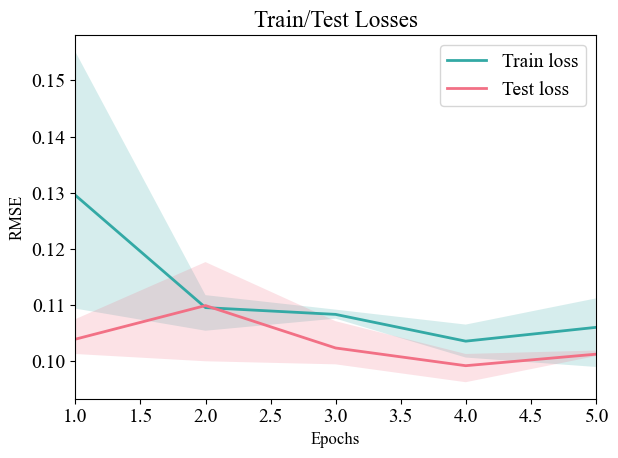

In [14]:
plot_train_test_losses(train_arr,test_arr, title="Train/Test Losses", x_label="Epochs", y_label="RMSE", min_max_bounds= True, tight_x_lim= True, save_path=f"results/RUN_{dt_string}_{USER}.png")

In [15]:
import csv

In [16]:
cv_results["MAE"],cv_results["R2"]

([0.08624090397587189, 0.08550006208511499, 0.08729928244764988],
 [-1.2332634467345018, -2.7192489871611962, -1.3356860967782826])

In [17]:
cv_results['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results['R2_MEAN'] = np.mean(cv_results['R2'])
cv_results['MAE_MEAN'],cv_results['R2_MEAN']

(0.08634674950287892, -1.7627328435579936)

In [18]:
cv_results['NUM_WORKERS'] = NUM_WORKERS
cv_results['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results['LEARNING_RATE'] = LEARNING_RATE
cv_results['NUM_EPOCHS'] = NUM_EPOCHS
cv_results['LR_SCHEDULER'] = LR_SCHEDULER
cv_results['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results['SEEDS'] = SEEDS

In [19]:
with open(f"results/RUN_{dt_string}_{USER}.json", "w") as fp:
    json.dump(cv_results, fp, indent=4)

In [20]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)